# Baseline Model Notebook

## Unzip the file


In [2]:
import zipfile
import os
zip_file_path = 'cashflow_data.zip'
extract_path = os.path.dirname(zip_file_path)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_file_path))

## Import the datasets and delete the unziped folder

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
consumers = pd.read_parquet("cashflow/consumer_data.parquet")
transactions = pd.read_parquet('cashflow/transactions.parquet')
categories = pd.read_csv('transaction_categories.csv')


KeyboardInterrupt: 

In [ ]:
import shutil


In [7]:
os.path.dirname(zip_file_path)

''

In [8]:
os.rmdir('cashflow')

OSError: [Errno 66] Directory not empty: 'cashflow'

In [30]:
consumers.head()

,evaluation_date,FPF_TARGET,total_balance,masked_consumer_id
0,2021-08-26,0.0,1380.84,C01100001
1,2022-08-02,0.0,20163.90,C01100002
2,2021-03-04,0.0,3986.25,C01100003
3,2022-11-19,0.0,5956.03,C01100004
4,2021-11-21,0.0,29421.10,C01100005


16000 unique consumers

In [31]:
consumers['masked_consumer_id'].unique().shape

(16000,)

In [32]:
consumers.shape

(16000, 4)

In [33]:
transactions.shape

(17738083, 5)

In [34]:
transactions.head()

,masked_consumer_id,posted_date,amount,category,masked_transaction_id
2715977,C02103629,2022-08-12,-21.00,27.0,C02T02715977
2715978,C02103629,2022-08-09,-8.60,22.0,C02T02715978
2715979,C02103629,2022-08-07,-30.05,16.0,C02T02715979
2715980,C02103629,2022-09-29,-0.46,0.0,C02T02715980
2715981,C02103629,2022-07-21,-50.00,12.0,C02T02715981


In [35]:
categories.head()

,code,description
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS


In [36]:
# Merging dataframes
merged_df = pd.merge(transactions, categories, left_on='category', right_on='code', how='left')
merged_df = pd.merge(merged_df, consumers, left_on='masked_consumer_id', right_on='masked_consumer_id', how='left')

# Display the first few rows of the merged dataframe
merged_df.head()

,masked_consumer_id,posted_date,amount,category,masked_transaction_id,code,description,evaluation_date,FPF_TARGET,total_balance
0,C02103629,2022-08-12,-21.00,27.0,C02T02715977,27.0,HEALTHCARE_MEDICAL,2022-11-16,1.0,109.53
1,C02103629,2022-08-09,-8.60,22.0,C02T02715978,22.0,ESSENTIAL_SERVICES,2022-11-16,1.0,109.53
2,C02103629,2022-08-07,-30.05,16.0,C02T02715979,16.0,GENERAL_MERCHANDISE,2022-11-16,1.0,109.53
3,C02103629,2022-09-29,-0.46,0.0,C02T02715980,0.0,SELF_TRANSFER,2022-11-16,1.0,109.53
4,C02103629,2022-07-21,-50.00,12.0,C02T02715981,12.0,LOAN,2022-11-16,1.0,109.53


In [38]:
df = merged_df.head(1000)
# df.to_csv('cashflow/data_sample.csv')

In [39]:
merged_df.shape

(17738083, 10)

# Baseline Model (First Milestone)

#### Prof/TA comments or questions (4/16/2024):
1. Calculate loss in this
2. Check the # of defaults per "product" segment and how it's performing across each segment
3. AUC across each segment??
4. Model might be slow so use standard scalar for numeric values to speed up computations
5. Think of feature engineering per user basis (count of transactions per user, avg debit transaction amt , avg credit transaction amt )
6. Increase max iterations in logistic regression (Current 1000)

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

### Basic Features Engineering / Data Manipulation

Done in a hurry to get to the baseline model, needs more work

1. Transaction count per consumer
2. Average Debit Amount per consumer
3. Average Credit Amount per consumer
4. Count of Debits per consumer
5. Count of Credits per consumer
6. Dropped Date Columns (Check how to encode dates), skipped for now
7. Dropped rows with missing nulls
8. Encoded text fields using label encoder

In [41]:
# Drop problematic columns (check how to encode dates)
data = merged_df
data = data.drop(columns=['posted_date', 'evaluation_date', 'description', 'code'])

# Encode categorical variables
label_encoder = LabelEncoder()
data['product'] = data['masked_consumer_id'].apply(lambda x: x[:2])
data['product'] = label_encoder.fit_transform(data['product'].astype(str))
data['masked_transaction_id'] = label_encoder.fit_transform(data['masked_transaction_id'].astype(str))

In [42]:
is_credit = merged_df['amount'] > 0
is_debit = merged_df['amount'] < 0

# Create aggregations
consumer_features = merged_df.groupby('masked_consumer_id').agg(
    transactions_count=('masked_consumer_id', 'count'),
    average_debit_amount=('amount', lambda x: x[is_debit].mean()),
    average_credit_amount=('amount', lambda x: x[is_credit].mean()),
    count_of_credits=('amount', lambda x: x[is_credit].count()),
    count_of_debits=('amount', lambda x: x[is_debit].count())
).reset_index()

consumer_features.head()

,masked_consumer_id,transactions_count,average_debit_amount,average_credit_amount,count_of_credits,count_of_debits
0,C01100001,2658,-121.317871,896.000841,309,2349
1,C01100002,2489,-135.926139,904.673323,316,2173
2,C01100003,663,-148.624964,758.367117,111,552
3,C01100004,1084,-151.145475,402.589339,242,842
4,C01100005,2412,-218.482202,787.787646,514,1898


In [43]:
data = pd.merge(data, consumer_features, left_on='masked_consumer_id', right_on='masked_consumer_id', how='left')
data['masked_consumer_id'] = label_encoder.fit_transform(data['masked_consumer_id'].astype(str))

In [44]:
merged_df.head()

,masked_consumer_id,posted_date,amount,category,masked_transaction_id,code,description,evaluation_date,FPF_TARGET,total_balance
0,C02103629,2022-08-12,-21.00,27.0,C02T02715977,27.0,HEALTHCARE_MEDICAL,2022-11-16,1.0,109.53
1,C02103629,2022-08-09,-8.60,22.0,C02T02715978,22.0,ESSENTIAL_SERVICES,2022-11-16,1.0,109.53
2,C02103629,2022-08-07,-30.05,16.0,C02T02715979,16.0,GENERAL_MERCHANDISE,2022-11-16,1.0,109.53
3,C02103629,2022-09-29,-0.46,0.0,C02T02715980,0.0,SELF_TRANSFER,2022-11-16,1.0,109.53
4,C02103629,2022-07-21,-50.00,12.0,C02T02715981,12.0,LOAN,2022-11-16,1.0,109.53


In [45]:
data.head()

,masked_consumer_id,amount,category,masked_transaction_id,FPF_TARGET,total_balance,product,transactions_count,average_debit_amount,average_credit_amount,count_of_credits,count_of_debits
0,6909,-21.00,27.0,6025240,1.0,109.53,0,672,-42.520075,165.738832,137,535
1,6909,-8.60,22.0,6025241,1.0,109.53,0,672,-42.520075,165.738832,137,535
2,6909,-30.05,16.0,6025242,1.0,109.53,0,672,-42.520075,165.738832,137,535
3,6909,-0.46,0.0,6025244,1.0,109.53,0,672,-42.520075,165.738832,137,535
4,6909,-50.00,12.0,6025245,1.0,109.53,0,672,-42.520075,165.738832,137,535


#### Only ~122 rows missing, dropping it for now

In [46]:
# Check for missing values
data.isnull().sum()

masked_consumer_id          0
amount                    121
category                  121
masked_transaction_id       0
FPF_TARGET                  0
total_balance               1
product                     0
transactions_count          0
average_debit_amount      182
average_credit_amount    4295
count_of_credits            0
count_of_debits             0
dtype: int64

In [47]:
data = data.dropna()
data.shape

(17733727, 12)

#### Imputing X values (skipping right now)

In [48]:
# from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer

# # Create a pipeline that includes imputation and the logistic regression model
# pipeline = make_pipeline(
#     SimpleImputer(strategy='mean'),  # Impute missing values with the mean of the column
#     LogisticRegression(random_state=42, max_iter=1000)
# )

# # Fit the pipeline on the training data
# pipeline.fit(X_train, y_train)

# # Predict on the test set
# y_pred_pipeline = pipeline.predict(X_test)

# # Evaluate the model
# classification_report_pipeline = classification_report(y_test, y_pred_pipeline)


In [49]:
# Split data into features and target
X = data.drop('FPF_TARGET', axis=1)
y = data['FPF_TARGET']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Fit the Logistic Regression model on the cleaned dataset
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [51]:
# Predict on the test set
y_pred = logistic_model.predict(X_test)

In [52]:
# Evaluate the model
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94   3148971
         1.0       0.00      0.00      0.00    397775

    accuracy                           0.89   3546746
   macro avg       0.44      0.50      0.47   3546746
weighted avg       0.79      0.89      0.84   3546746



In [53]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

print(accuracy)

88.78191446469525


In [54]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the positive class (class label 1)
y_probabilities = logistic_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_probabilities)
auc_score


0.8087106648018073

## EDA (ignore for now)

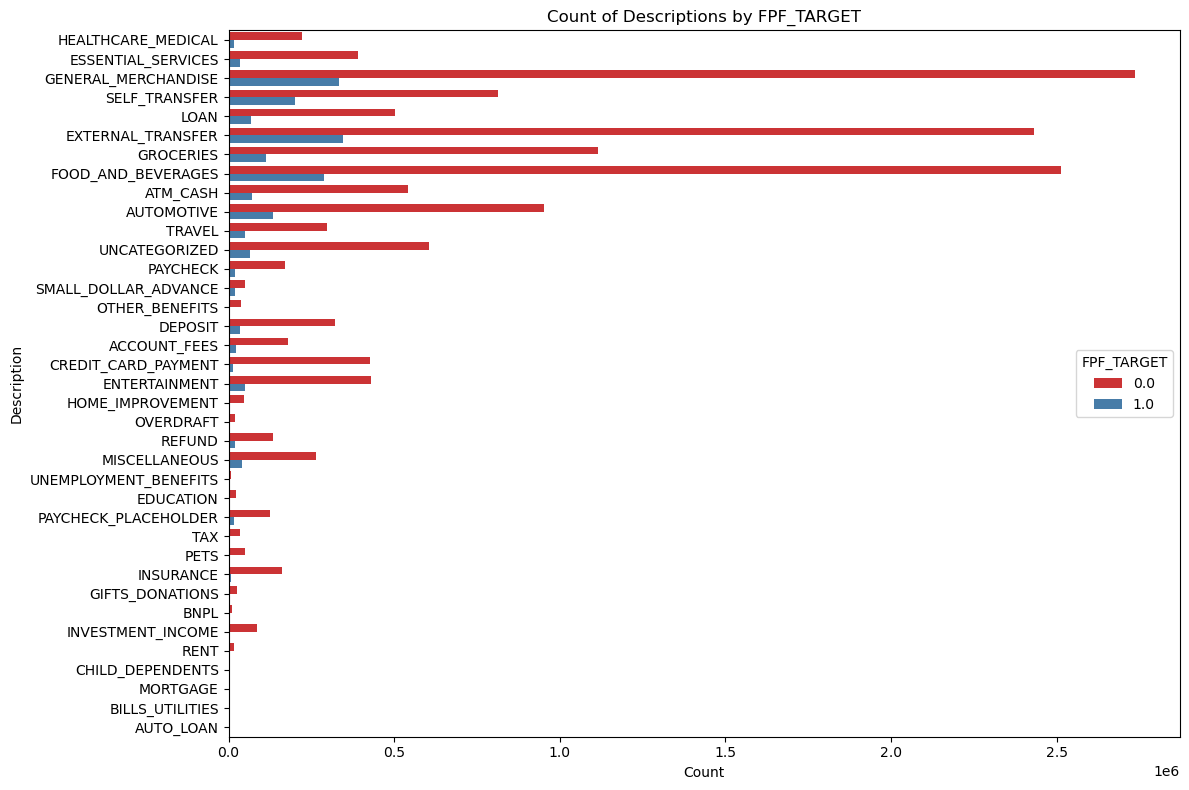

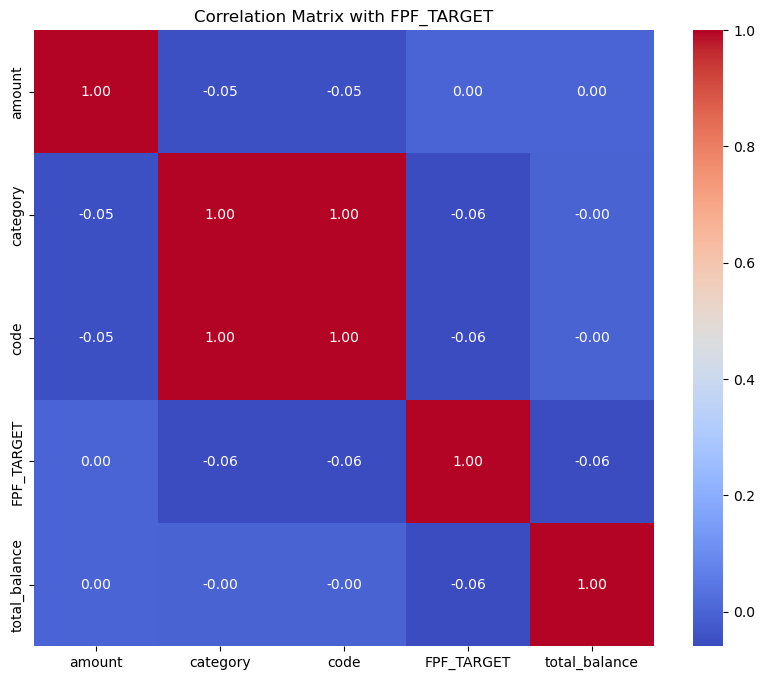

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

data = merged_df

plt.figure(figsize=(12, 8))
sns.countplot(y='description', hue='FPF_TARGET', data=data, palette='Set1')
plt.title('Count of Descriptions by FPF_TARGET')
plt.xlabel('Count')
plt.ylabel('Description')
plt.legend(title='FPF_TARGET')
plt.tight_layout()
plt.show()

# Calculate the correlation matrix
corr_data = data[['amount', 'category',
       'code',
       'FPF_TARGET', 'total_balance']]
correlation_matrix = corr_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with FPF_TARGET')
plt.show()